In [1]:
import sklearn
from collections import defaultdict as dd
import pandas as pd
import numpy as np
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import precision_recall_fscore_support, classification_report, mutual_info_score
from sklearn.feature_selection import mutual_info_classif
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve

In [2]:
# This function opens a csv file and turns it into a dataframe with the index as the ID number
def preprocess(filename):
    df = pd.read_csv(filename, index_col=0)
    return df

In [3]:
# This function gets the features from the preproccessed dataframe
def features(df):
    features = df.iloc[:,25:].values.tolist()
    return features

In [4]:
# This function gets the actual/ground truth labels for the dataset
def actuals(df):
    actuals = df.loc[:,'Toxicity'].to_numpy()
    return actuals

# Data Import

In [5]:
emb_train = preprocess("train_embedding.csv")
emb_train_feat = features(emb_train)
emb_dev = preprocess("dev_embedding.csv")
emb_dev_feat = features(emb_dev)
emb_test = preprocess("test_embedding.csv")
emb_test_feat = features(emb_test)

In [6]:
raw_train = preprocess("train_raw.csv")
raw_dev = preprocess("dev_raw.csv")
raw_test = preprocess("test_raw.csv")

In [7]:
tfidf_train = preprocess("train_tfidf.csv")
tfidf_train_feat = features(tfidf_train)
tfidf_dev = preprocess("dev_tfidf.csv")
tfidf_dev_feat = features(tfidf_dev)
tfidf_test = preprocess("test_tfidf.csv")
tfidf_test_feat = features(tfidf_test)

In [8]:
emb_unlab = preprocess("unlabeled_embedding.csv")
emb_unlab_feat = features(emb_unlab)
tfidf_unlab = preprocess("unlabeled_tfidf.csv")
tfidf_unlab_feat = features(tfidf_unlab)

In [9]:
actual_train = actuals(emb_train)

In [11]:
print(len(emb_train_feat), len(emb_test_feat), len(emb_unlab_feat))

140000 15000 200000


# Evaluations

In [110]:
def evaluation(model, df, features):
    evals = {}
    dev_actuals = actuals(df)
    y_pred = model.predict(features)
    p_r_f = precision_recall_fscore_support(\
                    dev_actuals, y_pred, pos_label = 1, average = 'binary', zero_division = 0)
    evals['Precision'] = p_r_f[0]
    evals['Recall'] = p_r_f[1]
    evals['F-Score'] = p_r_f[2]
    evals['Accuracy'] = accuracy_score(dev_actuals, y_pred)
    if (model == tfidf_kmeans) or (model == emb_kmeans):
        evaluations = pd.Series(evals, name='Evaluation')
        return evaluations
    evals['ROC AUC'] = roc_auc_score(dev_actuals, model.predict_proba(features)[:, 1])
    evaluations = pd.Series(evals, name='Evaluation')

    return evaluations

# Test Predictions

In [13]:
def predictions(model, test_features):
    predictions = model.predict(test_features)
    return predictions

# Learning Curves

In [14]:
# CODE REPURPOSED FROM COMP90049 Lecture 12
from sklearn.model_selection import learning_curve
from sklearn.model_selection import StratifiedKFold
def plotlc(model, features, actual, k):
    train_sizes, train_scores, valid_scores = \
    learning_curve(model, features, actual, scoring='accuracy', cv=StratifiedKFold(k),
                  train_sizes = np.linspace(.1, 1.0, 5))
    plt.figure()
    plt.xlabel("Training Size")
    plt.ylabel("Accuracy")
    plt.plot(train_sizes, np.mean(train_scores, axis=1), 'o-', label="Training score")
    plt.plot(train_sizes, np.mean(valid_scores, axis=1), 'o-', label="Cross-validation score")
    plt.legend(loc="best")
    plt.show()
    

# Data Distribution

0    117514
1     22486
Name: Toxicity, dtype: int64


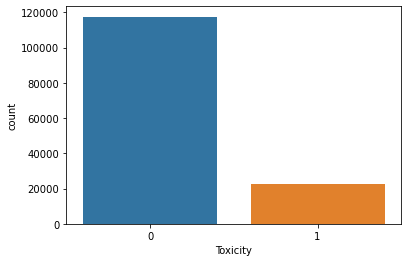

In [47]:
data_distrib = emb_train.loc[:,'Toxicity'].value_counts()
sns.countplot(data=emb_train, x="Toxicity")
print(data_distrib)

# Zero R

In [43]:
from sklearn.dummy import DummyClassifier
zeror = DummyClassifier(strategy="most_frequent")
zeror.fit(emb_train, actual_train)
evaluation(zeror, emb_dev, emb_dev_feat)

Precision    0.000
Recall       0.000
F-Score      0.000
Accuracy     0.811
ROC AUC      0.500
Name: Evaluation, dtype: float64

While the accuracy score for Zero-R is high it is not useful as we are interested in identifying toxic comments and given that the training data is skewed towards non-toxic comments, the classifier labels all instances as non-toxic. Hence we get precision, recall and f-scores of 0 since we are only interested in how the classifier performs in detecting toxic comments.

# Naive Bayes

In [17]:
from sklearn.naive_bayes import GaussianNB
nbG = GaussianNB()
nbG.fit(emb_train_feat, actual_train)

GaussianNB()

In [111]:
evaluation(nbG, emb_dev, emb_dev_feat)

Precision    0.335849
Recall       0.690653
F-Score      0.451933
Accuracy     0.683400
ROC AUC      0.749058
Name: Evaluation, dtype: float64

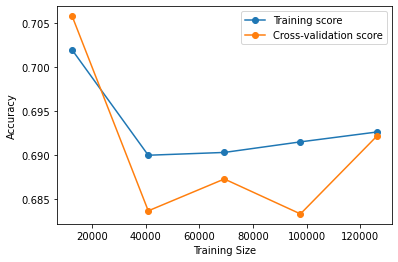

In [19]:
plotlc(GaussianNB(), emb_train_feat, actual_train, 10)

In [20]:
from sklearn.naive_bayes import MultinomialNB
nbM = MultinomialNB()
nbM.fit(tfidf_train_feat, actual_train)

MultinomialNB()

In [45]:
evaluation(nbM, tfidf_dev, tfidf_dev_feat)

Precision    0.736111
Recall       0.018695
F-Score      0.036464
Accuracy     0.813267
ROC AUC      0.764673
Name: Evaluation, dtype: float64

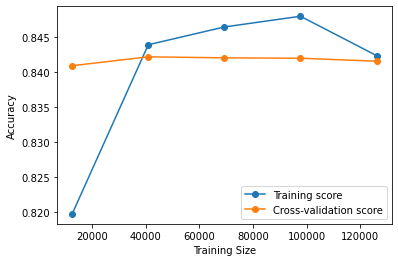

In [22]:
plotlc(MultinomialNB(), tfidf_train_feat, actual_train, 10)

# Logistic Regression

In [23]:
from sklearn.linear_model import LogisticRegression

emb_logr = LogisticRegression(solver='saga').fit(emb_train_feat, actual_train)
tfidf_logr = LogisticRegression(solver='saga').fit(tfidf_train_feat, actual_train)

In [46]:
print("Embedding:")
print(evaluation(emb_logr, emb_dev, emb_dev_feat))
print()
print("TF-IDF:")
print(evaluation(tfidf_logr, tfidf_dev, tfidf_dev_feat))

Embedding:
Precision    0.652915
Recall       0.256790
F-Score      0.368608
Accuracy     0.833733
ROC AUC      0.816595
Name: Evaluation, dtype: float64

TF-IDF:
Precision    0.638368
Recall       0.204233
F-Score      0.309460
Accuracy     0.827733
ROC AUC      0.784487
Name: Evaluation, dtype: float64


In [25]:
emb_logr_pred = predictions(emb_logr, emb_test_feat)
tfidf_logr_pred = predictions(tfidf_logr, tfidf_test_feat)

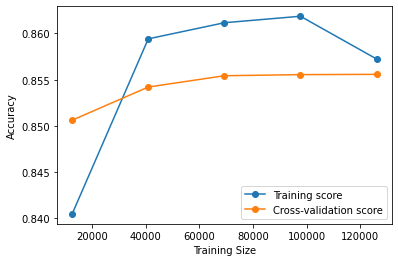

In [26]:
plotlc(LogisticRegression(solver='saga'), emb_train_feat, actual_train, 10)

# DBScan

In [100]:
# CODE REPURPOSED FROM COMP90014 Week_08_Dimensionality Tutorial
def distance_matrix_to_coordinates(dimension, matrix):
    embedding = dimension(n_components=2, learning_rate='auto', random_state=1, init='pca', perplexity=50)
    np_arr = np.array(matrix)
    matrix_2dims = embedding.fit_transform(np_arr)
    return matrix_2dims

In [79]:
# CODE REPURPOSED FROM COMP90014 Week_05_Kmeans Tutorial
from sklearn.cluster import DBSCAN

db = DBSCAN(eps=6.8, min_samples=10).fit(TSNEt_distances_xy)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print('Estimated number of clusters: {}'.format(n_clusters_))
print('Estimated number of noise points: {}'.format( n_noise_))

Estimated number of clusters: 2
Estimated number of noise points: 8


In [80]:
from collections import defaultdict as dd
count = dd(int)
for a in labels:
    count[a] += 1
print(count)

defaultdict(<class 'int'>, {0: 199832, -1: 8, 1: 160})


In [82]:
db_unlab = tfidf_unlab.copy()
db_unlab["Toxic"] = labels

In [31]:
from sklearn.manifold import TSNE

In [124]:
# CODE REPURPOSED FROM COMP90014 Week_08_Dimensionality Tutorial
def TSNE_scatterplot(tsne_matrix, unlab, title):
    instance = unlab.iloc[:, 0].values.tolist()
    x_coords = [x[0] for x in tsne_matrix]
    y_coords = [x[1] for x in tsne_matrix]
    rng = np.random.RandomState(0)
    fig, ax = plt.subplots(figsize=(12, 12))
    #plt.figsize(12, 12)
    ax.scatter(x_coords, y_coords, label=instance, cmap='viridis')
    plt.title(title)
    plt.show()

C:\Users\JULIAN\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


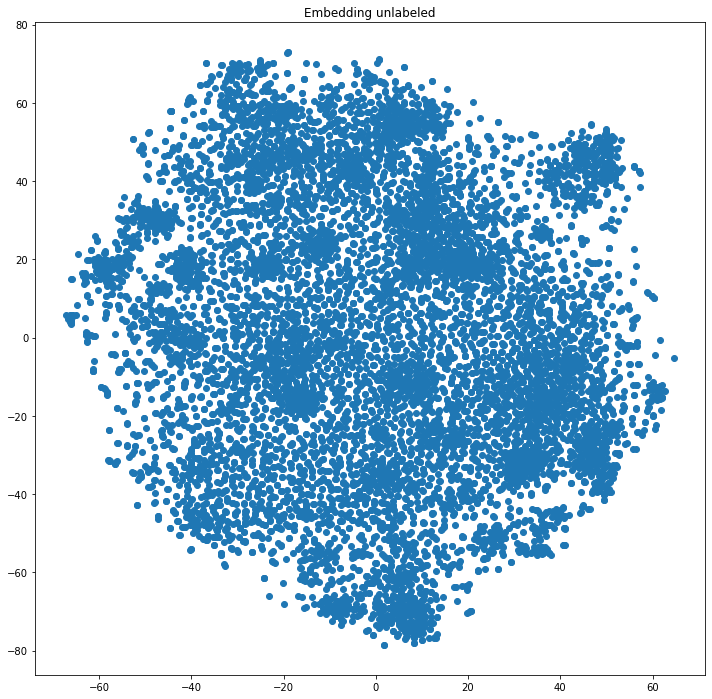

In [125]:
# CODE REPURPOSED FROM COMP90014 Week_08_Dimensionality Tutorial
TSNE_distances_xy = distance_matrix_to_coordinates(TSNE, emb_unlab_feat[:10000])
TSNE_scatterplot(TSNE_distances_xy, emb_unlab[:10000], "Embedding unlabeled")

C:\Users\JULIAN\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


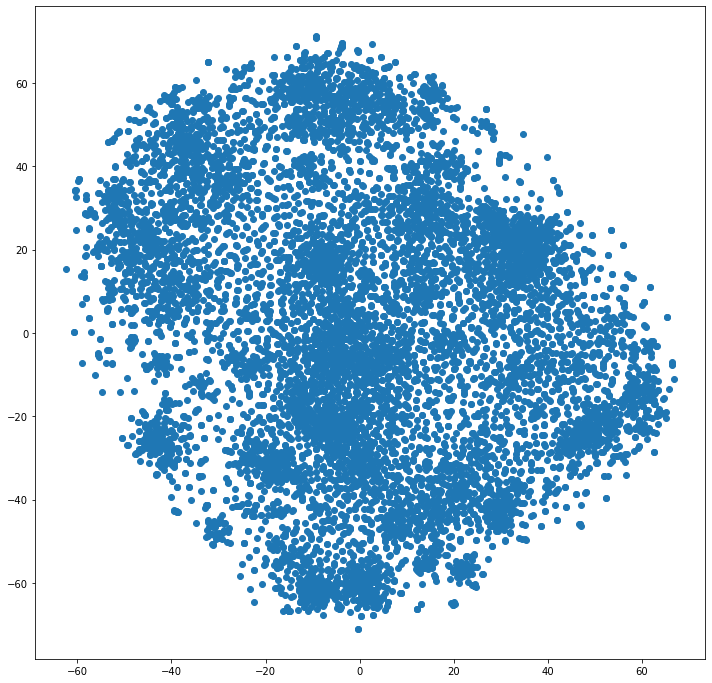

In [102]:
# CODE REPURPOSED FROM COMP90014 Week_08_Dimensionality Tutorial
TSNE_distances_xy = distance_matrix_to_coordinates(TSNE, emb_train_feat[:10000])
TSNE_scatterplot(TSNE_distances_xy, emb_train[:10000], "Embedding train")

C:\Users\JULIAN\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


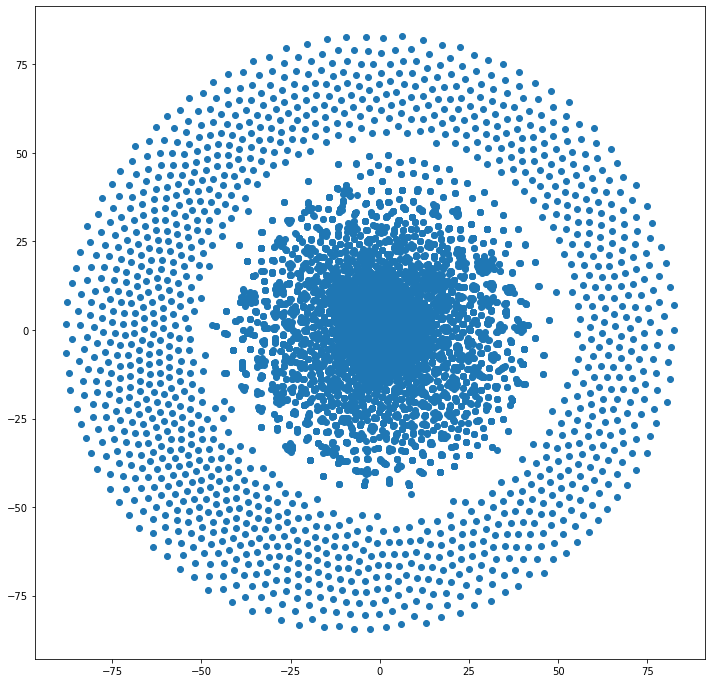

In [106]:
# CODE REPURPOSED FROM COMP90014 Week_08_Dimensionality Tutorial
TSNEt_distances_xy = distance_matrix_to_coordinates(TSNE, tfidf_unlab_feat[:10000])
TSNE_scatterplot(TSNEt_distances_xy, tfidf_unlab[:10000],"TFIDF unlabeled")

C:\Users\JULIAN\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


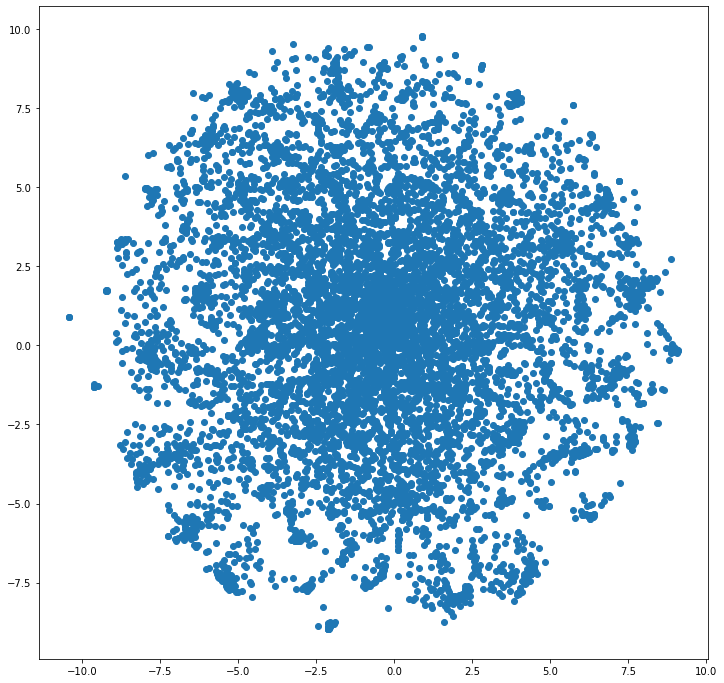

In [103]:
# CODE REPURPOSED FROM COMP90014 Week_08_Dimensionality Tutorial
TSNEtrain_distances_xy = distance_matrix_to_coordinates(TSNE, tfidf_train_feat[:10000])
TSNE_scatterplot(TSNEtrain_distances_xy, tfidf_train[:10000],"TFIDF train")

# K-means

In [112]:
from sklearn.cluster import KMeans
for i in range(10):
    tfidf_kmeans = KMeans(n_clusters=2, random_state=i).fit(tfidf_train_feat)
    print(evaluation(tfidf_kmeans, tfidf_dev, tfidf_dev_feat))

Precision    0.155296
Recall       0.674427
F-Score      0.252459
Accuracy     0.245133
Name: Evaluation, dtype: float64
Precision    0.155314
Recall       0.674780
F-Score      0.252508
Accuracy     0.244933
Name: Evaluation, dtype: float64
Precision    0.343378
Recall       0.325573
F-Score      0.334239
Accuracy     0.754867
Name: Evaluation, dtype: float64
Precision    0.155296
Recall       0.674427
F-Score      0.252459
Accuracy     0.245133
Name: Evaluation, dtype: float64
Precision    0.155296
Recall       0.674427
F-Score      0.252459
Accuracy     0.245133
Name: Evaluation, dtype: float64
Precision    0.343378
Recall       0.325573
F-Score      0.334239
Accuracy     0.754867
Name: Evaluation, dtype: float64
Precision    0.155845
Recall       0.679012
F-Score      0.253506
Accuracy     0.244200
Name: Evaluation, dtype: float64
Precision    0.193253
Recall       0.848677
F-Score      0.314818
Accuracy     0.301800
Name: Evaluation, dtype: float64
Precision    0.155308
Recall    

In [52]:
for i in range(10):
    emb_kmeans = KMeans(n_clusters=2, random_state=i).fit(emb_train_feat)
    print(evaluation(emb_kmeans, emb_dev, emb_dev_feat))

Precision    0.087906
Recall       0.119224
F-Score      0.101198
Accuracy     0.599733
Name: Evaluation, dtype: float64
Precision    0.087861
Recall       0.119224
F-Score      0.101167
Accuracy     0.599600
Name: Evaluation, dtype: float64
Precision    0.223846
Recall       0.880776
F-Score      0.356969
Accuracy     0.400267
Name: Evaluation, dtype: float64
Precision    0.223866
Recall       0.880776
F-Score      0.356995
Accuracy     0.400333
Name: Evaluation, dtype: float64
Precision    0.223846
Recall       0.880776
F-Score      0.356969
Accuracy     0.400267
Name: Evaluation, dtype: float64
Precision    0.087884
Recall       0.119224
F-Score      0.101182
Accuracy     0.599667
Name: Evaluation, dtype: float64
Precision    0.223846
Recall       0.880776
F-Score      0.356969
Accuracy     0.400267
Name: Evaluation, dtype: float64
Precision    0.087906
Recall       0.119224
F-Score      0.101198
Accuracy     0.599733
Name: Evaluation, dtype: float64
Precision    0.087884
Recall    

# CSV Output

In [ ]:
def csv(test, predictions, filename):
    csv_output = pd.read_csv(test, usecols=[0], index_col=0)
    csv_output['Toxicity'] = predictions
    csv_output.to_csv(filename)

In [ ]:
#csv("test_embedding.csv", emb_logr_pred, "pred_emb_logr.csv")

In [ ]:
#csv("test_tfidf.csv", tfidf_logr_pred, "pred_tfidf_logr.csv")